In [538]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import random

In [539]:
limInf=-1
limSup=3
def f(T):
    ans =  (T**3-5*T+np.cos(T)*np.sin(10*T))*50
    return ans

# limInf=40
# limSup=90
# def f(T):
#     ans = (204165.5)/(330-2*T)+(10400)/(T-20)
#     return ans

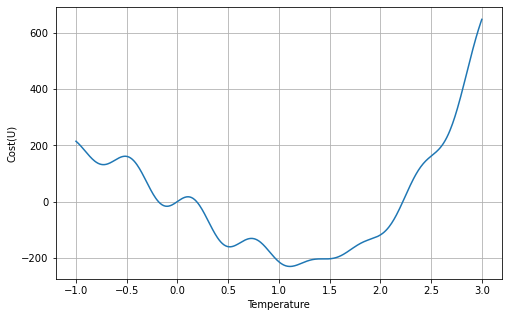

In [540]:
t = np.linspace(limInf,limSup,500)
fu=f(t)
fig1 = plt.figure(figsize=(8,5))
plt.plot(t,fu)
plt.xlabel("Temperature")
plt.ylabel("Cost(U)")
plt.grid(True)

In [541]:
#Generar una cadena aleatoria de genes
def genDNAList(length:int,name:str):
    adnString = [[name,random.choice(["0","1"])] for i in range(length)]
    
    #adnString = ''.join(random.choice(["0","1"]) for i in range(length))
    #print(adnString)
    return adnString

#decodificar una cadena de genes
def decodeDNAString(adnString:str,limInf:float,limSup:float):
    num = int(adnString,2)                  #Este es un int
    numBits = len(adnString)                #Número de bits
    base = (limSup-limInf)/(2**numBits-1)   #Resolución por cada bit
    return base*num + limInf

def encodeDNAString(xi:float,name:str,numBits:int,limInf:float,limSup:float):
    VD = (xi-limInf)*(2**numBits-1)/(limSup-limInf)
    redondeo = int(VD)
    binariString = format(redondeo,str(numBits)+'b')        
    adnString = [[name,bit] for bit in binariString[1:]]    #Se codifica un bit de más
    return adnString

#definir una función que genere n individuos
def genIndividuals(names:dict,numBits,limInf:float,limSup:float):
    ans = []
    for i in names.keys():
        ans.append(encodeDNAString(names[i],i,numBits,limInf,limSup))
    return ans

#print(encodeDNAString(1.439,"Ignacio",8,-1,2))

# print(genDNAList(5,"Luis"))
# names = ["Luis","Nacho","Ignacio"]
# población = genIndividuals(names,8)


In [542]:
#Evaluar la fución
def evaluarFunción(población:list):
    fx = []
    for i in población:
        #for gen in i: print(gen) 
        listaAux = [gen[1] for gen in i]
        stringAux = ''.join(map(str, listaAux))
        fx.append(f(decodeDNAString(stringAux,limInf,limSup)))
    return fx

#Evaluar fitness
def evaluarFitness(fx):
    #Escalar fx a valores positivos si es necesario:
    if min(fx)<0:
        #print("Valor negativo encontrado")
        for i in range(len(fx)):
            fx[i] = fx[i]+abs(min(fx))
    #Normalización de fx en Fi
    Fi = []
    for eval in fx:
        Fi.append(1/(1+eval))
    return Fi


# MÉTODOS

# Torneo

In [543]:
def torneo(numIndividuos,Fi,población,numBits):
    padres = []
    ids = [j for j in range(numIndividuos)] #0 hasta numIndividuos-1
    for i in range(numIndividuos):
        oponente = random.choice(ids)       #Elegir un oponente al azar
        # print(i,oponente)
        # print(Fi[i],Fi[oponente])
        if Fi[i]>Fi[oponente]:
            padres.append(población[i])         #el ganador local
        else:
            padres.append(población[oponente])  #ganador visitante
    return padres

#padres = torneo(numIndividuos,Fi,población,numBits)    #individuos ganadores


# Ruleta

In [544]:
def ruleta(numIndividuos,Fi,población,numBits):
    total = 0
    for fi in Fi:
        total = total+fi
    #print(total)
    #sacar probabilidad
    #nota: la probabilidad es diferentes y casi siempre esta muy cargada
    prob = []
    for fi in Fi:
        prob.append(fi/total)
    from numpy.random import choice
    indexs = [i for i in range(len(población))]
    indexs = choice(indexs, numIndividuos, True, p=prob)
    padres = [población[i] for i in indexs]
    #print(padres)
    return padres

  # Rank

In [545]:
#probabilidades
def ps(n): #n es el num de individuos
    probs= []
    j=1
    suman=n*(n+1)/2 # es la suma de numeros consecutivos desde 1 hasta "n"
    #print(suman)
    for i in range(n):
        prob=j/suman
        probs.append(prob)
        j=j+1   #A calay !!
    return probs

In [546]:
# funcion Rank
def rank(numIndividuos,Fi,población,numBits):
    probabilidades = ps(numIndividuos)
    #print (población)
    
    #Ordenar las listas

    acoplamiento = zip(Fi,población) #zip: acopla las listas
    paresOrdenados = sorted(acoplamiento) #ordena deacuerdo al primer arreglo:acomplamiento y regresa pares ordenados
    tuples = zip(*paresOrdenados) #devuelve una lista de pares ordenados 
    basura,rank = [ list(tuple) for tuple in  tuples] #desacoplan #nos interesa el rank ordenado: lista poblacion ordenada deac. al fitness
    
    from numpy.random import choice
    #nota:rank es la problación ordenada deacuerdo a su fitness
    indexs = [i for i in range(len(población))]
    indexs = choice(indexs, numIndividuos, True, p=probabilidades)
    padres = [población[i] for i in indexs]
    
    # for r in rank:
    #     print(f(decodeDNAString(r,limInf,limSup)))
    # #print(probabilidades)
    return padres

# Cross

In [547]:
def crossAndMutation(padres,numIndividuos,numBits,probMuta=0.02):
    #Cruzado
    #choice: le das n numeros para sacar de la tombola y le pides el tamaño de la tombola
    from numpy.random import default_rng
    rng = default_rng()
    hijos=[]

    for i in range(numIndividuos):
        indices = rng.choice(numIndividuos,size=2,replace=False) #Que trucazo!!!
        puntocross = random.randint(1,numBits-2) #apartir de que bit voy a agarrar los genes del primer ind y del otro
        #vamos a tomar la subcadena del padre 
        left = padres[indices[0]][0:puntocross] #[primer individuo] [gen 0:puntocross-1]
        right = padres[indices[1]][puntocross:numBits] # [2 individuo][gen puntocross:final]
        hijos.append(left+right) 

    #Mutación
    for i in range(numIndividuos):
        if random.uniform(0,1) <= probMuta:
            #muta
            bitmutado = random.randint(1,numBits-1) #Para saber cual bit va a mutar            
            name    =hijos[i][bitmutado][0]
            gen     =hijos[i][bitmutado][1]
            #print(name,gen)
            if gen == '0':      #Modificar el bit en la lista: se modifica el bit de 0 a 1 o de 1 a 0
                hijos[i][bitmutado] = [name+" +",'1']
            else:
                hijos[i][bitmutado] = [name+" +",'0']
             
    return hijos

# Escoger

In [548]:

def optGen(método:str,names:list,numBits:int,generaciones:int,probMuta=0.02,función=f,limInf=40,limSup=90):
    #Generar población:
    población = genIndividuals(names,numBits,limInf,limSup)
    
    for i in range(generaciones):
        #Evaluar la función
        fx = evaluarFunción(población)
        #Evaluar el fitness
        Fi = evaluarFitness(fx)
        
        if(método=="torneo"):
            padres = torneo(len(names),Fi,población,numBits)
        elif(método=="ruleta"):
            padres = ruleta(len(names),Fi,población,numBits)
        elif(método=="rank"):
            padres = rank(len(names),Fi,población,numBits)
        else:
            print("Error FATAL, método no reconocido")
            return None,None,None
            
        población = crossAndMutation(padres,len(names),numBits,probMuta)

        #si la función es igual al minimo, ¿que individuo es?
        mejor = población[fx.index(min(fx))]
        listaAux = [gen[1] for gen in mejor]
        stringAux = ''.join(map(str, listaAux))
        xmin = decodeDNAString(stringAux,limInf,limSup)
        fmin = f(xmin)

        # listaAux = [gen[1] for gen in i]
        # stringAux = ''.join(map(str, listaAux))
        # fx.append(f(decodeDNAString(stringAux,limInf,limSup)))
    
    return población,mejor,xmin,fmin

In [549]:
names = {
    "Luis":-0.5,
    "Nacho":1.2,
    "Dr Gama":-0.75,
    "Naram":1.53,
    "Jacqueline":1.59,
    "Dr Efren":2.5,
    "Chike":1.43
}

población,mejor,xmin,fmin = optGen("rank",names,256,10,limInf=limInf,limSup=limSup)

In [550]:
#Resultados
#print(población)
#print("\n \n")
#print("El mejor individuo es:\t",mejor)
print("xmin = ","\033[92m",xmin,'\033[0m',sep="")
print("f(xmin) =",fmin)


xmin = 0.17999999970197678
f(xmin) = 3.197292577772509


In [551]:
#Porcentajes de la solución
tablaParticipación = dict.fromkeys(names.keys())

for i in tablaParticipación:
    tablaParticipación[i] = 0
    pass

for i in tablaParticipación.keys():
    sum = 0
    for element in mejor:
        if element[0].startswith(i):
            sum = sum+1
    tablaParticipación[i]=(sum/len(mejor))*100

#Ordenar
tablaParticipación = dict(sorted(tablaParticipación.items(), key=lambda item: item[1],reverse=True))

#Tabla de participación
# Print the names of the columns.
print ("{:<10} {:<10}".format('Nombre','Participación %'))
 
# print each data item.
for key, value in tablaParticipación.items():
    print ("{:<10} {:<10}".format(key,value))



Nombre     Participación %
Jacqueline 37.254901960784316
Dr Gama    26.27450980392157
Dr Efren   26.27450980392157
Chike      10.196078431372548
Luis       0.0       
Nacho      0.0       
Naram      0.0       
